In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Import Libraries

In [1]:
# Importing essential libraries

# General-purpose libraries
import os
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# For displaying plots inline (if using Jupyter Notebook)
# Comment this out if not using a Jupyter notebook
# %matplotlib inline

# Image and video processing
import cv2
from skimage.transform import resize

# Keras / TensorFlow (prefer consistent use of tensorflow.keras)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization,
    Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [3]:

!unzip Eye_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Eye Dataset/Train_Data/s0018_01649_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01651_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01653_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01654_0_0_0_0_0_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01655_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01657_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01658_0_0_0_0_0_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01659_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01660_0_0_0_0_0_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01661_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01663_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01664_0_0_0_0_0_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01665_0_0_0_0_1_01.png  
  inflating: Eye Dataset/Train_Data/s0018_01666_0_0_0_0_0_01.png  
  inflating

#Dataset Preparation

In [4]:
def label_img(img):
    word_label = img.split('_')[4]
    if word_label[0] == '1': return 1
    elif word_label[0] == '0': return 0
    #[1] eyes are open
    #[0] eyes are closed

def create_dataset(dir):
    dataset_path = []
    dataset_label = []
    for img in tqdm(os.listdir(dir)):
        label = label_img(img)
        if np.array(label) == 1:
            label_str = 'open'
        if np.array(label) == 0:
            label_str = 'close'
        path = os.path.join(dir, img)
        #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        dataset_path.append(path)
        dataset_label.append(label_str)
    df = pd.DataFrame()
    df['Path'] = dataset_path
    df['Label'] = dataset_label
    #np.save('train_data.npy', dataset)
    return df

In [5]:
train_dir = '/content/Eye Dataset/Train_Data/'
test_dir = '/content/Eye Dataset/Test_Data/'
train_df = create_dataset(train_dir)
test_df = create_dataset(test_dir)

100%|██████████| 14550/14550 [00:00<00:00, 310540.57it/s]


In [6]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="/content/Eye Dataset/Train_Data/",
                x_col="Path",
                y_col="Label",
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
val_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="/content/Eye Dataset/Train_Data/",
                x_col="Path",
                y_col="Label",
                subset="validation",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
test_gen = test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="/content/Eye Dataset/Test_Data/",
                x_col="Path",
                y_col="Label",
                batch_size=32,
                seed=42,
                shuffle=False,
                class_mode="binary",
                target_size=(100,100))
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)


Found 24468 validated image filenames belonging to 2 classes.
Found 8155 validated image filenames belonging to 2 classes.
Found 14550 validated image filenames belonging to 2 classes.
{'close': 0, 'open': 1}
{'close': 0, 'open': 1}
{'close': 0, 'open': 1}


#Model

In [7]:

# Initialize the VGG model

#base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)
#base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)


# Freeze all the layers
for layer in base_model.layers[:]:
    layer.trainable = True

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(base_model)
model.add(Flatten())
#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()
# Configure the model for training
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,976,833 (121.98 MB)

 Trainable params: 31,923,713 (121.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

#Training

In [11]:
import os

# File and folder paths
weight_name = 'resnet50.weights.h5'
weight_save_path = '/content/weights/'
model_name = 'resnet50_model.h5'
model_save_path = '/content/models/'

# Make sure the directories exist
os.makedirs(weight_save_path, exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-9)
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, mode='min', restore_best_weights=True)
checkpoint1 = ModelCheckpoint(weight_save_path + weight_name, monitor='val_accuracy', save_best_only=True, save_weights_only=True)
checkpoint2 = ModelCheckpoint(model_save_path + model_name, monitor='val_accuracy', save_best_only=False, save_weights_only=False)

# Train the model with integer steps
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,  # integer division
    validation_data = val_gen,
    validation_steps = val_gen.samples // val_gen.batch_size,    # integer division
    epochs = 30,
    callbacks = [lr_reduce, checkpoint1, checkpoint2]
)



Epoch 1/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9280 - loss: 1.0766

764/764 ━━━━━━━━━━━━━━━━━━━━ 147s 136ms/step - accuracy: 0.9280 - loss: 1.0756 - val_accuracy: 0.7350 - val_loss: 23.7001 - learning_rate: 0.0010
Epoch 2/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:57 154ms/step - accuracy: 0.9688 - loss: 0.0727

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


764/764 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9688 - loss: 0.0727 - val_accuracy: 0.7355 - val_loss: 9.7350 - learning_rate: 0.0010
Epoch 3/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9834 - loss: 0.0610

764/764 ━━━━━━━━━━━━━━━━━━━━ 141s 109ms/step - accuracy: 0.9834 - loss: 0.0610 - val_accuracy: 0.9551 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 4/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:47 141ms/step - accuracy: 1.0000 - loss: 0.0052

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9547 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 5/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9883 - loss: 0.0350

764/764 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - accuracy: 0.9883 - loss: 0.0350 - val_accuracy: 0.9897 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:40 131ms/step - accuracy: 1.0000 - loss: 0.0068

764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9899 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 7/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9908 - loss: 0.0283

764/764 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.9908 - loss: 0.0283 - val_accuracy: 0.9891 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 8/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:41 133ms/step - accuracy: 1.0000 - loss: 0.0118

764/764 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.9876 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 9/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9920 - loss: 0.0247
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


764/764 ━━━━━━━━━━━━━━━━━━━━ 84s 110ms/step - accuracy: 0.9920 - loss: 0.0247 - val_accuracy: 0.9908 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 10/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:41 133ms/step - accuracy: 1.0000 - loss: 5.4610e-04

764/764 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 1.0000 - loss: 5.4610e-04 - val_accuracy: 0.9909 - val_loss: 0.0293 - learning_rate: 5.0000e-04
Epoch 11/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9946 - loss: 0.0146

764/764 ━━━━━━━━━━━━━━━━━━━━ 127s 102ms/step - accuracy: 0.9946 - loss: 0.0147 - val_accuracy: 0.9777 - val_loss: 0.0548 - learning_rate: 5.0000e-04
Epoch 12/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:03 84ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9777 - val_loss: 0.0554 - learning_rate: 5.0000e-04
Epoch 13/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9964 - loss: 0.0101

764/764 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.9964 - loss: 0.0101 - val_accuracy: 0.9934 - val_loss: 0.0203 - learning_rate: 2.5000e-04
Epoch 14/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:42 135ms/step - accuracy: 1.0000 - loss: 8.8037e-05

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 8.8037e-05 - val_accuracy: 0.9932 - val_loss: 0.0206 - learning_rate: 2.5000e-04
Epoch 15/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9965 - loss: 0.0091

764/764 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.9965 - loss: 0.0091 - val_accuracy: 0.9910 - val_loss: 0.0337 - learning_rate: 2.5000e-04
Epoch 16/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 1.0000 - loss: 8.6274e-08
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 8.6274e-08 - val_accuracy: 0.9911 - val_loss: 0.0335 - learning_rate: 2.5000e-04
Epoch 17/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9980 - loss: 0.0058

764/764 ━━━━━━━━━━━━━━━━━━━━ 138s 107ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.9919 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 18/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:43 135ms/step - accuracy: 1.0000 - loss: 6.4242e-06

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 6.4242e-06 - val_accuracy: 0.9915 - val_loss: 0.0269 - learning_rate: 1.2500e-04
Epoch 19/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9983 - loss: 0.0049
Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


764/764 ━━━━━━━━━━━━━━━━━━━━ 130s 102ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9924 - val_loss: 0.0311 - learning_rate: 1.2500e-04
Epoch 20/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 1.0000 - loss: 3.3117e-06

764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 1.0000 - loss: 3.3117e-06 - val_accuracy: 0.9925 - val_loss: 0.0307 - learning_rate: 6.2500e-05
Epoch 21/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9984 - loss: 0.0041

764/764 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.9919 - val_loss: 0.0345 - learning_rate: 6.2500e-05
Epoch 22/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:03 83ms/step - accuracy: 1.0000 - loss: 8.0396e-07
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 8.0396e-07 - val_accuracy: 0.9920 - val_loss: 0.0341 - learning_rate: 6.2500e-05
Epoch 23/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9989 - loss: 0.0028

764/764 ━━━━━━━━━━━━━━━━━━━━ 137s 108ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9916 - val_loss: 0.0337 - learning_rate: 3.1250e-05
Epoch 24/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:41 133ms/step - accuracy: 1.0000 - loss: 0.0119

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.9918 - val_loss: 0.0337 - learning_rate: 3.1250e-05
Epoch 25/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9989 - loss: 0.0027
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


764/764 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9989 - loss: 0.0027 - val_accuracy: 0.9918 - val_loss: 0.0358 - learning_rate: 3.1250e-05
Epoch 26/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:45 138ms/step - accuracy: 1.0000 - loss: 1.1691e-08

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 1.1691e-08 - val_accuracy: 0.9916 - val_loss: 0.0366 - learning_rate: 1.5625e-05
Epoch 27/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9989 - loss: 0.0028

764/764 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9914 - val_loss: 0.0374 - learning_rate: 1.5625e-05
Epoch 28/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:42 134ms/step - accuracy: 1.0000 - loss: 1.1375e-08
Epoch 28: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 1.0000 - loss: 1.1375e-08 - val_accuracy: 0.9915 - val_loss: 0.0374 - learning_rate: 1.5625e-05
Epoch 29/30
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9988 - loss: 0.0030

764/764 ━━━━━━━━━━━━━━━━━━━━ 131s 106ms/step - accuracy: 0.9988 - loss: 0.0030 - val_accuracy: 0.9920 - val_loss: 0.0375 - learning_rate: 7.8125e-06
Epoch 30/30
  1/764 ━━━━━━━━━━━━━━━━━━━━ 1:43 135ms/step - accuracy: 1.0000 - loss: 1.9509e-04

764/764 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 1.9509e-04 - val_accuracy: 0.9920 - val_loss: 0.0376 - learning_rate: 7.8125e-06


#Testing

In [13]:
from tensorflow import keras

# Adjust the paths to your local Colab storage paths where you saved the model and weights
model_path = '/content/models/resnet50_model.h5'
weights_path = ' /content/weights/resnet50.weights.h5' # weights file with .weights.h5 extension

# Load the entire saved model (architecture + weights)
model = keras.models.load_model(model_path)

# If you only saved weights and want to load weights separately, use:
# model.load_weights(weights_path)

# Optional: print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,976,835 (121.98 MB)

 Trainable params: 31,923,713 (121.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

In [14]:
# Ensure test_gen is a valid generator (e.g., from ImageDataGenerator.flow_from_directory)

# Calculate total steps for prediction
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

# Reset the generator before prediction (important to avoid misalignment)
test_gen.reset()

# Make predictions
pred = model.predict(
    test_gen,
    steps=STEP_SIZE_TEST + 1,  # +1 to cover any remaining samples
    verbose=1
)


455/455 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step


In [15]:
from sklearn.metrics import classification_report
import pandas as pd

# Get ground truth labels
test_labels = test_gen.classes

# Predicted classes using threshold 0.5
y_pred = (pred > 0.5).astype(int)

# If y_pred is shape (N, 1), flatten it
if y_pred.shape[1] == 1:
    y_pred = y_pred.flatten()

# Classification report
report = classification_report(test_labels, y_pred, output_dict=True)
result_df = pd.DataFrame(report).transpose()

print(result_df)


              precision    recall  f1-score       support
0              0.958448  0.989746  0.973846   6339.000000
1              0.991879  0.966874  0.979217   8211.000000
accuracy       0.976838  0.976838  0.976838      0.976838
macro avg      0.975163  0.978310  0.976531  14550.000000
weighted avg   0.977314  0.976838  0.976877  14550.000000


CONFUSION MATRIX ------------------


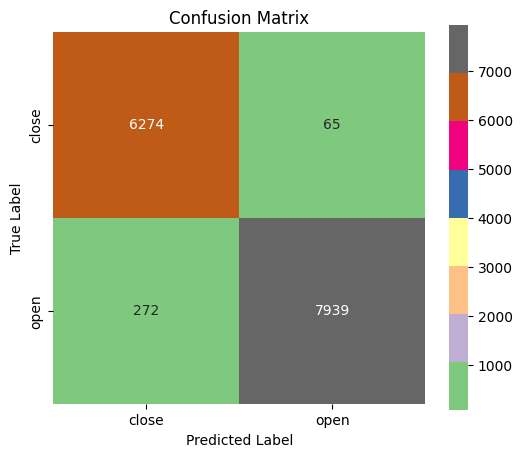

Sensitivity (for class "close"): 0.9897
Specificity (for class "open"): 0.9669


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

print('CONFUSION MATRIX ------------------')

# Plot heatmap
plt.figure(figsize=(6, 5))
ax = heatmap(cm, cmap='Accent', annot=True, fmt='d',
             xticklabels=['close', 'open'],
             yticklabels=['close', 'open'],
             square=True)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity (Recall for class 0 - "close")
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print('Sensitivity (for class "close"):', round(sensitivity, 4))

# Specificity (Recall for class 1 - "open")
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('Specificity (for class "open"):', round(specificity, 4))


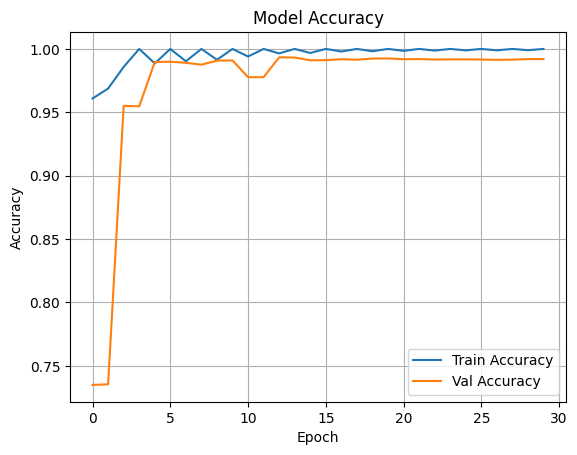

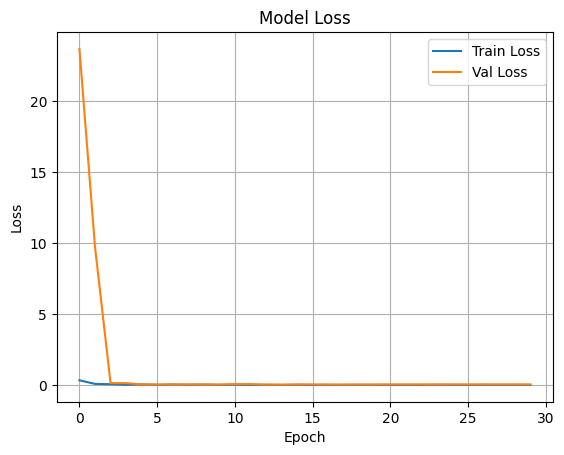

In [18]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


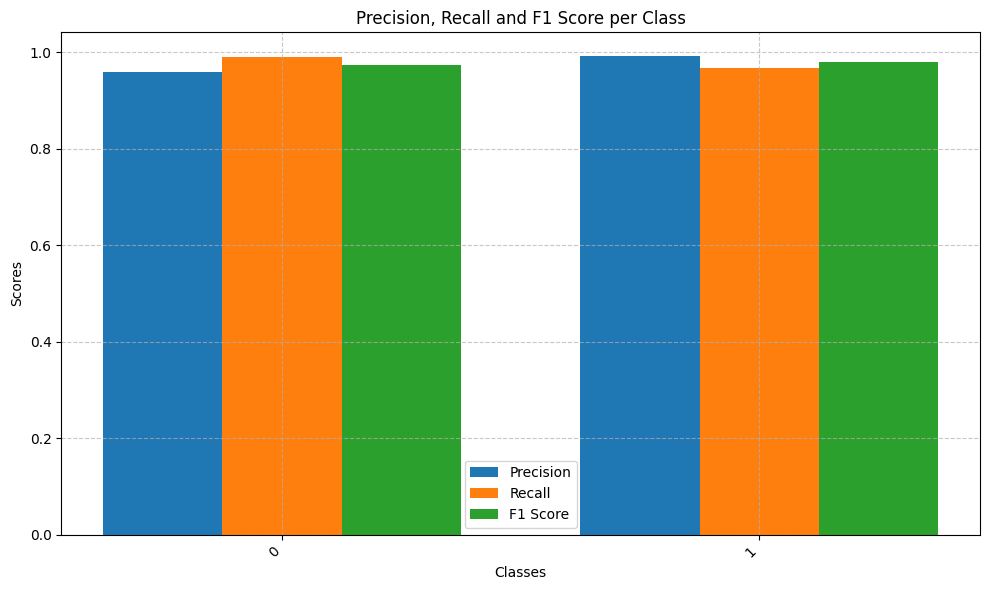

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only class rows (exclude 'accuracy', 'macro avg', 'weighted avg')
classes = [cls for cls in result_df.index if cls not in ['accuracy', 'macro avg', 'weighted avg']]

# Extract metrics for each class
precision = result_df.loc[classes, 'precision']
recall = result_df.loc[classes, 'recall']
f1_score = result_df.loc[classes, 'f1-score']

x = np.arange(len(classes))  # the label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1 Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


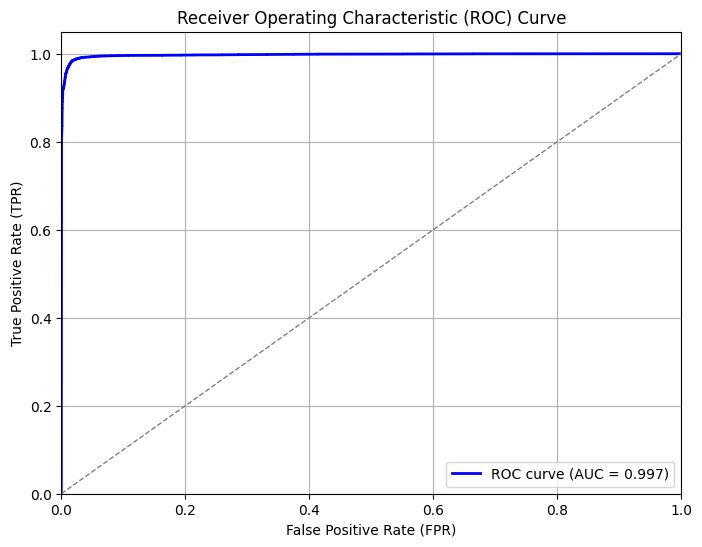

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_labels and pred are defined
# test_labels: true labels (binary)
# pred: predicted probabilities (shape: (num_samples, 1) or (num_samples,))

# Flatten predicted probabilities if needed
if pred.ndim > 1 and pred.shape[1] == 1:
    pred_probs = pred.flatten()
else:
    pred_probs = pred

# Compute ROC curve and ROC area for the positive class
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
